# 通用疾病预测 (Auto-Train 分类模型)

只需修改下方第一个代码单元中的数据路径 DATA_PATH，即可：
- 自动读取CSV
- 自动识别目标列（常见命名或唯一值较少的列）
- 自动完成预处理（数值标准化、类别独热编码）
- 自动尝试多种分类器并选择最佳
- 自动输出评估指标/图表，并保存最佳模型到 saved_models/

注意：
- 目标列命名建议包含 target/label/y/class/Outcome/HeartDisease/diagnosis/disease 等关键字之一；若未命中，将自动从“唯一值较少”的列中推断。
- 多分类与二分类均支持。
- 若类别极度不平衡，脚本会提示并自动使用带类权重的模型。

In [1]:
# 配置：仅需修改这一行
DATA_PATH = 'data_set/hypothyroid.csv'  # TODO: 改成你的CSV路径，如 'path/to/your.csv'
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 5

# 可选：排除明显是ID的列名关键词
ID_HINTS = ['id', 'uid', 'guid', 'index', '编号']

In [2]:
# 导入依赖
import os, sys, warnings, time, json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    roc_curve, auc, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

# 可选第三方模型
try:
    from xgboost import XGBClassifier
    _has_xgb = True
except Exception:
    _has_xgb = False

try:
    from lightgbm import LGBMClassifier
    _has_lgbm = True
except Exception:
    _has_lgbm = False

try:
    from catboost import CatBoostClassifier
    _has_cat = True
except Exception:
    _has_cat = False

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 读取数据
df = pd.read_csv(DATA_PATH)
print('数据维度:', df.shape)
display(df.head())
df_info = pd.DataFrame({
    'col': df.columns,
    'dtype': [str(t) for t in df.dtypes],
    'nunique': [df[c].nunique(dropna=False) for c in df.columns]
})
display(df_info)

数据维度: (3770, 30)


,Age,sex,thyroxine,queryonthyroxine,onantithyroidmedication,sick,pregnant,thyroidsurgery,I131treatment,queryhypothyroid,...,TT4measured,T4,T4Umeasured,T4U,FTImeasured,FTI,TBGmeasured,TBG,referral source,binaryClass
0,12,F,f,f,f,f,f,f,f,f,...,t,125.0,t,1.14,t,109.0,f,?,SVHC,P
1,20,M,f,f,f,f,f,f,f,f,...,t,102.0,f,0.00,f,0.0,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109.0,t,0.91,t,120.0,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175.0,f,0.00,f,0.0,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61.0,t,0.87,t,70.0,f,?,SVI,P


,col,dtype,nunique
0,Age,int64,93
1,sex,object,3
2,thyroxine,object,2
3,queryonthyroxine,object,2
4,onantithyroidmedication,object,2
5,sick,object,2
6,pregnant,object,2
7,thyroidsurgery,object,2
8,I131treatment,object,2
9,queryhypothyroid,object,2


In [4]:
# 自动识别目标列
def infer_target_column(frame: pd.DataFrame) -> str:
    cols_lower = {c: c.lower() for c in frame.columns}
    # 1) 优先常见命名
    common_names = ['target', 'label', 'y', 'class', 'outcome', 'heartdisease', 'diagnosis', 'disease', 'result']
    for key in common_names:
        for c, lc in cols_lower.items():
            if key == lc:
                return c
    # 2) 次优：包含关键字
    keywords = ['target', 'label', 'class', 'disease', 'health', 'outcome', 'status', 'diagnosis']
    candidates = []
    for c, lc in cols_lower.items():
        if any(k in lc for k in keywords):
            uniq = frame[c].nunique(dropna=False)
            if 2 <= uniq <= max(20, int(0.1 * len(frame))):
                candidates.append((c, uniq))
    if candidates:
        candidates.sort(key=lambda x: x[1])
        return candidates[0][0]
    # 3) 兜底：唯一值较少（适合分类）
    small_unique = []
    for c in frame.columns:
        uniq = frame[c].nunique(dropna=False)
        if 2 <= uniq <= max(20, int(0.1 * len(frame))):
            small_unique.append((c, uniq))
    if small_unique:
        small_unique.sort(key=lambda x: x[1])
        return small_unique[0][0]
    # 4) 最后：选择唯一值比例最小的列
    ratios = [(c, frame[c].nunique(dropna=False) / max(1, len(frame))) for c in frame.columns]
    ratios.sort(key=lambda x: x[1])
    return ratios[0][0]

target_col = infer_target_column(df)
print('自动识别目标列 ->', target_col)

自动识别目标列 -> binaryClass


In [5]:
# 拆分特征/标签，并自动处理ID列、类别/数值列
def detect_id_columns(cols):
    ids = []
    for c in cols:
        lc = c.lower()
        if any(h in lc for h in ID_HINTS):
            ids.append(c)
    return ids

id_cols = detect_id_columns([c for c in df.columns if c != target_col])
if id_cols:
    print('检测到可能的ID列，将自动丢弃:', id_cols)

y_raw = df[target_col]
X_raw = df.drop([target_col] + id_cols, axis=1)

# 将目标转成类别编码（支持二分类/多分类）
y = pd.Categorical(y_raw).codes

num_cols = X_raw.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()
cat_cols = X_raw.select_dtypes(include=['object','category','bool']).columns.tolist()
print(f'数值列: {len(num_cols)} 个, 类别列: {len(cat_cols)} 个, 特征总数: {X_raw.shape[1]}')

# 预处理器（数值标准化 + 类别独热）
# 兼容不同版本sklearn的OneHotEncoder参数
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', ohe, cat_cols)
    ], remainder='drop'
)

X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print('训练集/测试集:', X_train.shape, X_test.shape)
n_classes = len(np.unique(y))
print('类别数:', n_classes)

# 类别不平衡提示
cls_counts = pd.Series(y).value_counts(normalize=True).sort_index()
imbalance_ratio = cls_counts.max()
if imbalance_ratio >= 0.8:
    print('警告: 类别高度不平衡，已自动使用带类权重的模型进行对冲。')

检测到可能的ID列，将自动丢弃: ['onantithyroidmedication', 'thyroidsurgery', 'queryhypothyroid', 'queryhyperthyroid']
数值列: 6 个, 类别列: 19 个, 特征总数: 25
训练集/测试集: (3016, 25) (754, 25)
类别数: 2
警告: 类别高度不平衡，已自动使用带类权重的模型进行对冲。


In [ ]:
# 定义候选模型（自动跳过不可用库）
models = []

# 逻辑回归
models.append(('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced')))

# 随机森林
models.append(('RandomForest', RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight='balanced_subsample', random_state=RANDOM_STATE)))

# GBDT (sklearn)
models.append(('GBDT', GradientBoostingClassifier(random_state=RANDOM_STATE)))

# XGBoost
if _has_xgb:
    models.append(('XGBoost', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric='logloss',
        tree_method='hist',
        random_state=RANDOM_STATE
    )))

# LightGBM
if _has_lgbm:
    models.append(('LightGBM', LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=RANDOM_STATE
    )))

# CatBoost（静默）
if _has_cat:
    models.append(('CatBoost', CatBoostClassifier(
        depth=6, learning_rate=0.05, iterations=300, verbose=False, random_state=RANDOM_STATE
    )))

def get_scoring(n_cls):
    # 多分类使用ovr AUC，二分类使用AUC
    return 'roc_auc_ovr' if n_cls > 2 else 'roc_auc'

results = []
best_model = None
best_score = -np.inf
best_name = None

for name, clf in models:
    pipe = Pipeline([('prep', preprocessor), ('clf', clf)])
    scoring = get_scoring(n_classes)
    try:
        cv_scores = cross_val_score(pipe, X_train, y_train, cv=CV_FOLDS, scoring=scoring, n_jobs=None)
        cv_mean = float(np.mean(cv_scores))
    except Exception as e:
        print(f'[跳过CV] {name}:', e)
        cv_mean = np.nan
    # 拟合与测试
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    if n_classes == 2:
        try:
            y_proba = pipe.predict_proba(X_test)[:, 1]
            auc_score = roc_auc_score(y_test, y_proba)
        except Exception:
            auc_score = np.nan
        f1 = f1_score(y_test, y_pred)
    else:
        # 多分类
        try:
            y_proba = pipe.predict_proba(X_test)
            auc_score = roc_auc_score(y_test, y_proba, multi_class='ovr')
        except Exception:
            auc_score = np.nan
        f1 = f1_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)

    results.append({'模型': name, 'CV_AUC': cv_mean, 'Test_AUC': auc_score, 'Accuracy': acc, 'F1': f1})

    # 选择最佳：优先AUC, 其次F1, 再次Accuracy
    sel_score = (0 if np.isnan(auc_score) else auc_score) * 1.0 + f1 * 0.2 + acc * 0.1
    if sel_score > best_score:
        best_score = sel_score
        best_model = pipe
        best_name = name

res_df = pd.DataFrame(results)
display(res_df.sort_values(['Test_AUC','F1','Accuracy'], ascending=False))
print(f'当前最佳模型: {best_name}, 综合评分={best_score:.4f}')

NameError: name 'LogisticRegression' is not defined

最终选择的模型: CatBoost
Accuracy: 0.9986737400530504
F1: 0.9992810927390366
分类报告:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        58
           1       1.00      1.00      1.00       696

    accuracy                           1.00       754
   macro avg       0.99      1.00      1.00       754
weighted avg       1.00      1.00      1.00       754



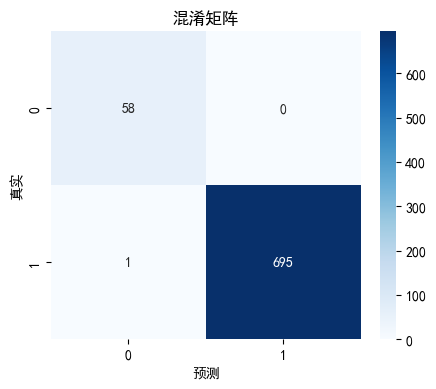

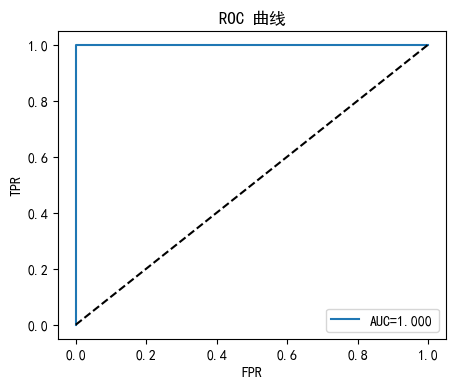

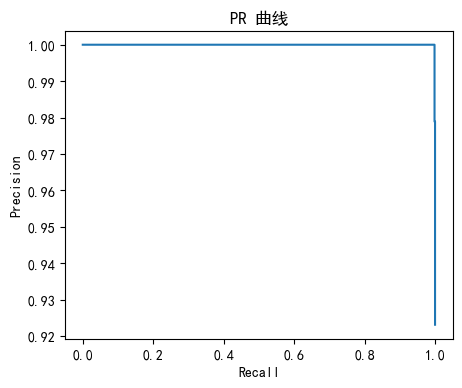

In [7]:
# 详细评估与可视化
print('最终选择的模型:', best_name)
y_pred = best_model.predict(X_test)
try:
    y_proba = best_model.predict_proba(X_test)
except Exception:
    y_proba = None

print('Accuracy:', accuracy_score(y_test, y_pred))
if n_classes == 2:
    print('F1:', f1_score(y_test, y_pred))
else:
    print('F1(weighted):', f1_score(y_test, y_pred, average='weighted'))
print('分类报告:')
print(classification_report(y_test, y_pred))

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('混淆矩阵')
plt.xlabel('预测')
plt.ylabel('真实')
plt.show()

# ROC & PR 曲线
if y_proba is not None:
    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_test, y_proba[:,1] if y_proba.ndim>1 else y_proba)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f'AUC={auc(fpr,tpr):.3f}')
        plt.plot([0,1],[0,1],'k--')
        plt.title('ROC 曲线')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend()
        plt.show()

        prec, rec, _ = precision_recall_curve(y_test, y_proba[:,1] if y_proba.ndim>1 else y_proba)
        plt.figure(figsize=(5,4))
        plt.plot(rec, prec)
        plt.title('PR 曲线')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
    else:
        # 多分类：绘制每一类的ROC（OvR）
        from sklearn.preprocessing import label_binarize
        y_bin = label_binarize(y_test, classes=sorted(np.unique(y)))
        plt.figure(figsize=(6,5))
        for i in range(y_proba.shape[1]):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'class {i} AUC={auc(fpr,tpr):.3f}')
        plt.plot([0,1],[0,1],'k--')
        plt.title('ROC 曲线 (OvR)')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend()
        plt.show()

In [8]:
# 保存最佳模型及元信息
import joblib
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)
ts = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = os.path.join(save_dir, f'best_pipeline_{best_name}_{ts}.pkl')
joblib.dump(best_model, model_path)

info = {
    'timestamp': ts,
    'data_path': DATA_PATH,
    'target_column': target_col,
    'n_features': int(X_raw.shape[1]),
    'n_classes': int(n_classes),
    'class_distribution': pd.Series(y).value_counts().to_dict(),
    'best_model': best_name
}
with open(os.path.join(save_dir, f'model_info_{ts}.json'), 'w', encoding='utf-8') as f:
    json.dump(info, f, ensure_ascii=False, indent=2)

print('模型已保存:', model_path)

模型已保存: saved_models\best_pipeline_CatBoost_20250903_110117.pkl


## 预测示例
将一行数据（必须包含与训练相同的列名与数据类型）组成DataFrame，调用 `best_model.predict` 即可。

In [9]:
# 示例：构造一条样本并预测（请按你的数据列名改造）
example = X_raw.iloc[[0]].copy()  # 复制一行已有数据结构作为模板
pred = best_model.predict(example)[0]
print('预测类别索引:', pred)

预测类别索引: 1
